# 🛒 Customer Segmentation for E-Commerce: RFM, Cohort Analysis & K-Means  

## 📌 Project Overview  
This project focuses on **customer segmentation** for a Brazilian e-commerce platform using **RFM analysis, cohort analysis, and K-Means clustering**. By analyzing historical customer transactions, we aim to uncover key purchasing behaviors and segment customers into meaningful groups for better business decision-making.  

## 🎯 Goals  
✔ Identify customer purchasing patterns using **RFM Analysis**  
✔ Analyze customer retention trends using **Cohort Analysis**  
✔ Apply **K-Means Clustering** for data-driven segmentation  
✔ Provide actionable insights for marketing strategies  

## 🔍 Dataset Information  
We will be using the **Olist Brazilian E-Commerce Dataset**, which contains various CSV files related to **orders, customers, payments, and items**.  

## 🛠️ Tools & Libraries  
- **Python**: `pandas`, `numpy`, `matplotlib`, `seaborn`, `sklearn`  
- **Segmentation Techniques**: `RFM Analysis`, `Cohort Analysis`, `K-Means Clustering`  

---  


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [81]:
# Load necessary libraries
import pandas as pd

# Load datasets
orders = pd.read_csv("olist_orders_dataset.csv")
payments = pd.read_csv("olist_order_payments_dataset.csv")
customers = pd.read_csv("olist_customers_dataset.csv")
order_items = pd.read_csv("olist_order_items_dataset.csv")

# Step 1: Merge orders with payments
rfm_data = orders.merge(payments, on="order_id", how="left")

# Step 2: Merge with customers
rfm_data = rfm_data.merge(customers, on="customer_id", how="left")

# Step 3: Merge with order_items
rfm_data = rfm_data.merge(order_items, on="order_id", how="left")


## Exploratory Data Analysis

In [82]:
#Checking for important information from the data
rfm_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118434 entries, 0 to 118433
Data columns (total 22 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       118434 non-null  object 
 1   customer_id                    118434 non-null  object 
 2   order_status                   118434 non-null  object 
 3   order_purchase_timestamp       118434 non-null  object 
 4   order_approved_at              118258 non-null  object 
 5   order_delivered_carrier_date   116360 non-null  object 
 6   order_delivered_customer_date  115037 non-null  object 
 7   order_estimated_delivery_date  118434 non-null  object 
 8   payment_sequential             118431 non-null  float64
 9   payment_type                   118431 non-null  object 
 10  payment_installments           118431 non-null  float64
 11  payment_value                  118431 non-null  float64
 12  customer_unique_id            

In [83]:
rfm_data.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 176
order_delivered_carrier_date     2074
order_delivered_customer_date    3397
order_estimated_delivery_date       0
payment_sequential                  3
payment_type                        3
payment_installments                3
payment_value                       3
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
order_item_id                     830
product_id                        830
seller_id                         830
shipping_limit_date               830
price                             830
freight_value                     830
dtype: int64

In [84]:
# Drop unnecessary unnecessary
rfm_data.drop(columns=['order_item_id','order_estimated_delivery_date','customer_zip_code_prefix', 'product_id', 'seller_id','customer_id', 'shipping_limit_date', 'price', 'freight_value', 'order_approved_at'], inplace=True)

# Drop the remaining columns
rfm_data.drop(columns=['payment_sequential', 'payment_installments'], inplace=True)

# Confirm missing values after cleaning
print("Missing Values After Cleaning:\n", rfm_data.isnull().sum())


Missing Values After Cleaning:
 order_id                            0
order_status                        0
order_purchase_timestamp            0
order_delivered_carrier_date     2074
order_delivered_customer_date    3397
payment_type                        3
payment_value                       3
customer_unique_id                  0
customer_city                       0
customer_state                      0
dtype: int64


In [85]:
# Fill missing values by assigning the result back to the column
rfm_data['order_delivered_customer_date'] = rfm_data['order_delivered_customer_date'].fillna("Not Delivered")
rfm_data['order_delivered_carrier_date'] = rfm_data['order_delivered_carrier_date'].fillna("Not Shipped")


In [86]:
#Dealing with missing values with the median
rfm_data['payment_value'].fillna(rfm_data['payment_value'].median(), inplace=True)

#Dealing with missing info with the mode in payment type
rfm_data['payment_type'].fillna(rfm_data['payment_type'].mode()[0], inplace=True)

In [87]:
#Checking to see if their are empty row
rfm_data.isna().sum()

order_id                         0
order_status                     0
order_purchase_timestamp         0
order_delivered_carrier_date     0
order_delivered_customer_date    0
payment_type                     0
payment_value                    0
customer_unique_id               0
customer_city                    0
customer_state                   0
dtype: int64

In [88]:
# Convert date columns to datetime for time series analysis
rfm_data['order_delivered_carrier_date'] = pd.to_datetime(rfm_data['order_delivered_carrier_date'], errors='coerce')
rfm_data['order_purchase_timestamp'] = pd.to_datetime(rfm_data['order_purchase_timestamp'], errors='coerce')
rfm_data['order_delivered_customer_date'] = pd.to_datetime(rfm_data['order_delivered_customer_date'], errors='coerce')


In [89]:
rfm_data

,order_id,order_status,order_purchase_timestamp,order_delivered_carrier_date,order_delivered_customer_date,payment_type,payment_value,customer_unique_id,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-04 19:55:00,2017-10-10 21:25:13,credit_card,18.12,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP
1,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-04 19:55:00,2017-10-10 21:25:13,voucher,2.00,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP
2,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-04 19:55:00,2017-10-10 21:25:13,voucher,18.59,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP
3,53cdb2fc8bc7dce0b6741e2150273451,delivered,2018-07-24 20:41:37,2018-07-26 14:31:00,2018-08-07 15:27:45,boleto,141.46,af07308b275d755c9edb36a90c618231,barreiras,BA
4,47770eb9100c2d0c44946d9cf07ec65d,delivered,2018-08-08 08:38:49,2018-08-08 13:50:00,2018-08-17 18:06:29,credit_card,179.12,3a653a41f6f9fc3d2a113cf8398680e8,vianopolis,GO
...,...,...,...,...,...,...,...,...,...,...
118429,63943bddc261676b46f01ca7ac2f7bd8,delivered,2018-02-06 12:58:58,2018-02-07 23:22:42,2018-02-28 17:37:56,credit_card,195.00,da62f9e57a76d978d02ab5362c509660,praia grande,SP
118430,83c1379a015df1e13d02aae0204711ab,delivered,2017-08-27 14:46:43,2017-08-28 20:52:26,2017-09-21 11:24:17,credit_card,271.01,737520a9aad80b3fbbdad19b66b37b30,nova vicosa,BA
118431,11c177c8e97725db2631073c19f07b62,delivered,2018-01-08 21:28:27,2018-01-12 15:35:03,2018-01-25 23:32:54,credit_card,441.16,5097a5312c8b157bb7be58ae360ef43c,japuiba,RJ
118432,11c177c8e97725db2631073c19f07b62,delivered,2018-01-08 21:28:27,2018-01-12 15:35:03,2018-01-25 23:32:54,credit_card,441.16,5097a5312c8b157bb7be58ae360ef43c,japuiba,RJ


In [92]:
rfm_data.dtypes

order_id                                 object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
payment_type                             object
payment_value                           float64
customer_unique_id                       object
customer_city                            object
customer_state                           object
dtype: object

In [93]:
#A summary Statistics of the data
rfm_data.describe().T

,count,mean,min,25%,50%,75%,max,std
order_purchase_timestamp,118434,2017-12-30 04:00:24.559636480,2016-09-04 21:15:19,2017-09-11 12:53:55.249999872,2018-01-17 17:57:56.500000,2018-05-03 19:05:01,2018-10-17 17:30:18,NaN
order_delivered_carrier_date,116360,2018-01-03 17:52:23.945324800,2016-10-08 10:34:01,2017-09-14 22:50:53.500000,2018-01-23 20:43:19,2018-05-07 16:31:45,2018-09-11 19:48:28,NaN
order_delivered_customer_date,115037,2018-01-13 06:29:34.791693312,2016-10-11 13:46:32,2017-09-25 13:56:47,2018-02-01 19:16:53,2018-05-15 16:51:55,2018-10-17 13:22:46,NaN
payment_value,118434.0,172.847757,0.0,60.86,108.2,189.24,13664.08,268.256631


In [94]:
rfm_data.shape # This confirm that no customer transaction is lost,except that unnecessary columns are removed

(118434, 10)

In [95]:
#Analyze Order Status Impact
#To see if order status affects payment value

order_status_payment = rfm_data.groupby("order_status")["payment_value"].agg(["mean", "count"]).sort_values("mean", ascending=False)
print(order_status_payment)


                    mean   count
order_status                    
processing    267.675653     375
canceled      250.958819     745
invoiced      220.940724     373
unavailable   194.879538     650
delivered     171.912629  115038
shipped       158.353526    1245
created       137.620000       5
approved      100.900000       3


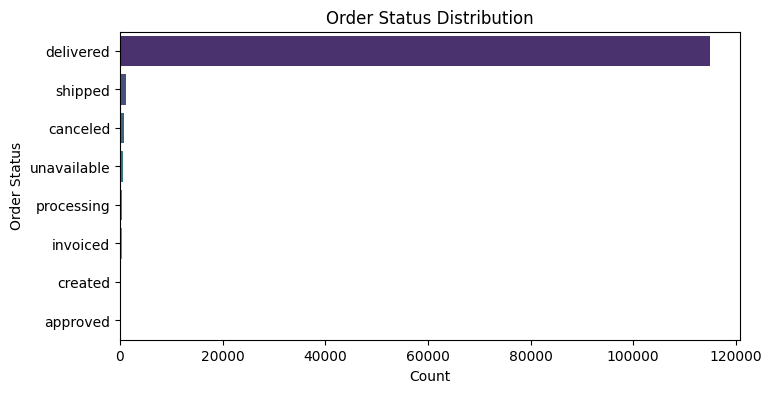

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count of each order status
plt.figure(figsize=(8, 4))
sns.countplot(y=rfm_data['order_status'], order=rfm_data['order_status'].value_counts().index, palette='viridis')
plt.title("Order Status Distribution")
plt.xlabel("Count")
plt.ylabel("Order Status")
plt.show()


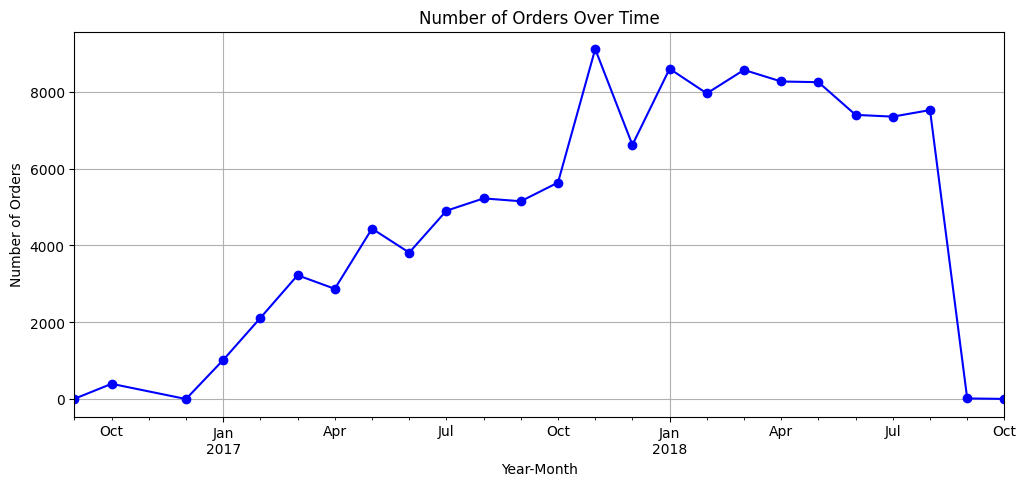

In [67]:
# Convert purchase timestamp to datetime format
rfm_data['order_purchase_timestamp'] = pd.to_datetime(rfm_data['order_purchase_timestamp'])

# Extract year-month for trend analysis
rfm_data['order_month'] = rfm_data['order_purchase_timestamp'].dt.to_period('M')

# Plot purchase trends
plt.figure(figsize=(12, 5))
rfm_data['order_month'].value_counts().sort_index().plot(kind='line', marker='o', color='b')
plt.title("Number of Orders Over Time")
plt.xlabel("Year-Month")
plt.ylabel("Number of Orders")
plt.grid()
plt.show()


In [68]:
#Explore Payment Type Preferences
#To see if a payment type is linked to higher spending:
rfm_data.groupby("payment_type")["payment_value"].mean().sort_values(ascending=False)


payment_type
credit_card    179.807426
boleto         177.402470
debit_card     151.011731
voucher         67.520242
not_defined      0.000000
Name: payment_value, dtype: float64

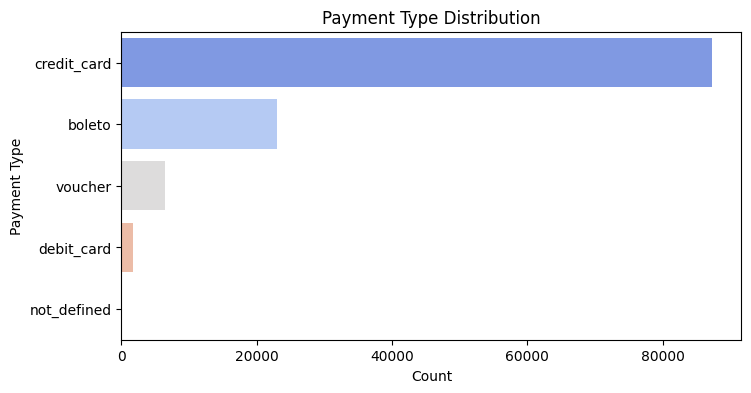

In [97]:
# Count of payment types
plt.figure(figsize=(8, 4))
sns.countplot(y=rfm_data['payment_type'], order=rfm_data['payment_type'].value_counts().index, palette='coolwarm')
plt.title("Payment Type Distribution")
plt.xlabel("Count")
plt.ylabel("Payment Type")
plt.show()


In [98]:
#Finding Which cities have high-value transactions
#Do customers in certain states pay more on average?

rfm_data.groupby("customer_city")["payment_value"].mean().sort_values(ascending=False).head(10)

customer_city
pianco                     2324.990000
nova esperanca do piria    2252.660000
engenheiro navarro         2106.550000
mariental                  1867.850000
paranatinga                1687.186667
loreto                     1643.640000
ibitita                    1534.580000
barao ataliba nogueira     1351.510000
barra longa                1341.550000
passagem                   1265.830000
Name: payment_value, dtype: float64

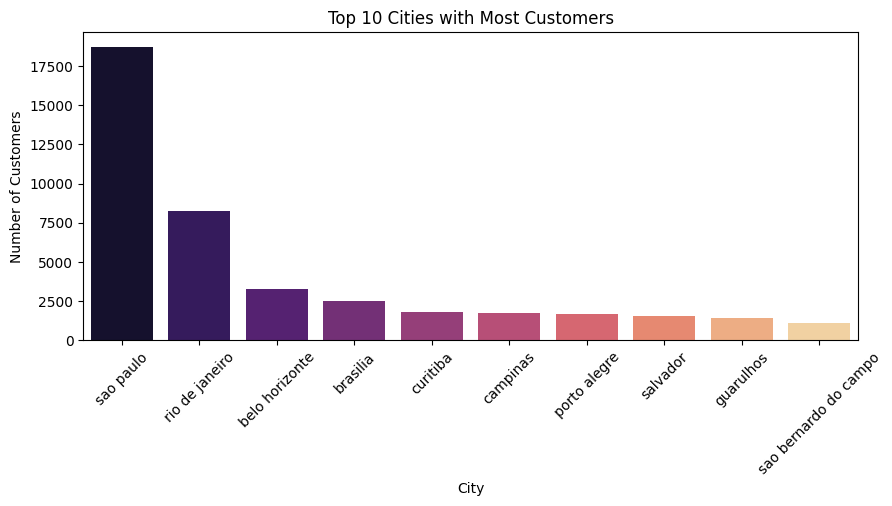

In [99]:
# Top 10 cities with most customers
top_cities = rfm_data['customer_city'].value_counts().head(10)

plt.figure(figsize=(10, 4))
sns.barplot(x=top_cities.index, y=top_cities.values, palette='magma')
plt.xticks(rotation=45)
plt.title("Top 10 Cities with Most Customers")
plt.xlabel("City")
plt.ylabel("Number of Customers")
plt.show()


In [111]:
rfm_data.loc[rfm_data['order_status'] == 'canceled', 'order_delivered_customer_date'] = pd.NaT


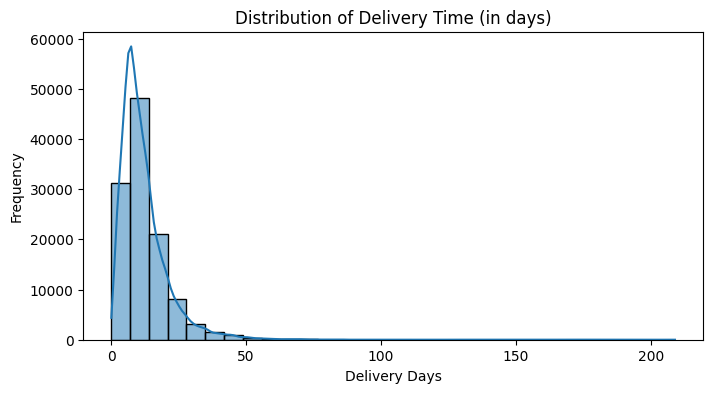

In [112]:
# Calculate delivery time
rfm_data['delivery_days'] = (rfm_data['order_delivered_customer_date'] - rfm_data['order_purchase_timestamp']).dt.days

# Plot distribution of delivery time
plt.figure(figsize=(8, 4))
sns.histplot(rfm_data['delivery_days'].dropna(), bins=30, kde=True)
plt.title("Distribution of Delivery Time (in days)")
plt.xlabel("Delivery Days")
plt.ylabel("Frequency")
plt.show()


In [100]:
rfm_data.dtypes

order_id                                 object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
payment_type                             object
payment_value                           float64
customer_unique_id                       object
customer_city                            object
customer_state                           object
dtype: object

In [101]:
# Group by customer city and order status
city_cancellation = rfm_data[rfm_data["order_status"] == "canceled"].groupby("customer_city")["payment_value"].mean().sort_values(ascending=False)
print(city_cancellation.head(10))  # Top 10 cities with highest average canceled payment_value


customer_city
novo hamburgo    2404.720000
paranagua        1950.200000
goiania          1551.040000
quissama         1400.740000
porto alegre     1381.022000
florianopolis    1371.608000
porto seguro     1346.410000
piratininga       898.510000
uberaba           845.088000
praia grande      818.563333
Name: payment_value, dtype: float64


In [113]:
# Compare average delivery time for different order statuses
delivery_analysis = rfm_data.groupby("order_status")["delivery_days"].mean().sort_values()
print(delivery_analysis)

order_status
delivered      12.018873
approved             NaN
canceled             NaN
created              NaN
invoiced             NaN
processing           NaN
shipped              NaN
unavailable          NaN
Name: delivery_days, dtype: float64


In [114]:
#The cleaned data after EDA
rfm_data

,order_id,order_status,order_purchase_timestamp,order_delivered_carrier_date,order_delivered_customer_date,payment_type,payment_value,customer_unique_id,customer_city,customer_state,delivery_days
0,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-04 19:55:00,2017-10-10 21:25:13,credit_card,18.12,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP,8.0
1,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-04 19:55:00,2017-10-10 21:25:13,voucher,2.00,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP,8.0
2,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-04 19:55:00,2017-10-10 21:25:13,voucher,18.59,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP,8.0
3,53cdb2fc8bc7dce0b6741e2150273451,delivered,2018-07-24 20:41:37,2018-07-26 14:31:00,2018-08-07 15:27:45,boleto,141.46,af07308b275d755c9edb36a90c618231,barreiras,BA,13.0
4,47770eb9100c2d0c44946d9cf07ec65d,delivered,2018-08-08 08:38:49,2018-08-08 13:50:00,2018-08-17 18:06:29,credit_card,179.12,3a653a41f6f9fc3d2a113cf8398680e8,vianopolis,GO,9.0
...,...,...,...,...,...,...,...,...,...,...,...
118429,63943bddc261676b46f01ca7ac2f7bd8,delivered,2018-02-06 12:58:58,2018-02-07 23:22:42,2018-02-28 17:37:56,credit_card,195.00,da62f9e57a76d978d02ab5362c509660,praia grande,SP,22.0
118430,83c1379a015df1e13d02aae0204711ab,delivered,2017-08-27 14:46:43,2017-08-28 20:52:26,2017-09-21 11:24:17,credit_card,271.01,737520a9aad80b3fbbdad19b66b37b30,nova vicosa,BA,24.0
118431,11c177c8e97725db2631073c19f07b62,delivered,2018-01-08 21:28:27,2018-01-12 15:35:03,2018-01-25 23:32:54,credit_card,441.16,5097a5312c8b157bb7be58ae360ef43c,japuiba,RJ,17.0
118432,11c177c8e97725db2631073c19f07b62,delivered,2018-01-08 21:28:27,2018-01-12 15:35:03,2018-01-25 23:32:54,credit_card,441.16,5097a5312c8b157bb7be58ae360ef43c,japuiba,RJ,17.0
